In [3]:
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Tuple

In [5]:
# for preprocessing 
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer

# to split data 
from sklearn.model_selection import train_test_split, cross_val_score

# TO Evaluation 
from sklearn.metrics import accuracy_score , precision_score ,recall_score , f1_score
from sklearn.metrics import confusion_matrix , classification_report 

# classification models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

# Decision Tree for Classification problems

**Decision Tree Learning** is a supervised learning method used for both classification and regression problems. As suggested by its name, it is a **tree-based** method, i.e. a method that makes use of a *tree* data structure. In this notebook, we show how to fit a decision tree using the `scikit-learn` library, working on a public dataset such as the *breast-cancer dataset*. In particular, we will focus on a classification problem, namely that of predicting whether a cancer patient is alive or dead based on some input features. Before analzing the dataset, let's make a brief theoretical introduction about decision trees. 

## Theoretical introduction

For the sake of simplicity, let's assume that all features in our problem have discrete domains, and there is a single target variable we want to predict, which we will refer to as the *classification*. Each possible value of the classification variable is typically called a *class*.

As mentioned in the introduction, decision tree learning is based on a tree data structure. A tree consists of nodes and branches. In a decision tree, each internal node represents a feature, and the branches correspond to the possible values of that feature. The tree builds its structure by splitting the dataset at each node based on a set of splitting rules derived from the feature values.

Let’s consider a simple example with a dataset that includes only one feature and a target variable. Our decision tree will have a single node representing that feature, and two branches—each corresponding to one of the feature’s possible values. If most of the data points with a particular feature value lead to the same class label, we can define a basic rule: for example, *if feature = A, then class = X*. The goal of a decision tree is to automatically learn the best such rules to accurately predict the target variable. Of course, we will later provide a more rigorous definition of what we mean by "most."

When the dataset contains multiple features, this splitting process is applied recursively. At each step, the algorithm chooses the feature that results in the most informative split. This continues until either (1) all examples at a node share the same class label, or (2) no further splitting improves the prediction quality. The final layer of the tree, where no further splitting occurs, is called the **leaf** layer. Each leaf typically represents a class prediction, sometimes accompanied by a probability distribution over the classes.

This recursive approach is known as **Top-Down Induction of Decision Trees (TDIDT)**.

![Decision-Tree](../images/survival-titanics.jpg)

Above, an example of a decision tree taken from [Wikipedia](https://en.wikipedia.org/wiki/Decision_tree_learning).

### Metrics

A decision tree builds its structure by iteratively splitting the dataset into subsets, choosing at each step the feature that results in the "best" separation of the data. But how do we define what the "best" split is?
There are several metrics that can be used to evaluate the quality of a split. These metrics define different algorithms and splitting strategies. In this notebook, we will focus on one of the most commonly used metrics: the **Gini index**.
The Gini index is a measure of **impurity** or disorder in a dataset. Intuitively, it quantifies how often a randomly chosen element from the set would be incorrectly classified if it were randomly labeled according to the distribution of class labels in the set. The more mixed the classes are in a dataset, the higher the Gini index will be.

Let’s assume the target variable has $K$ possible classes, labeled with indices $i = 1, 2, \dots, K$. Let $p_i$ denote the proportion of examples in the dataset that belong to class $i$ (i.e., $p_i = \frac{N_i}{N}$, where $N_i$ is the number of samples in class $i$, and $N$ is the total number of samples).
$$
G = \sum_i^K p_i(1-p_i) = 1 - \sum_i^K p_i^2
$$

- If all examples belong to a single class (i.e., the node is pure), then the Gini index is 0.
- If the examples are uniformly distributed across all classes (i.e., maximum disorder), the Gini index reaches its maximum value.

During training, for each potential split, the dataset at a given node is divided into two subsets, $S_1$ and $S_2$, with sizes $N_1$ and $N_2$, respectively. The quality of the split is evaluated by computing the weighted average of the Gini indices of the resulting subsets:
$$
G_{split} = \frac{N_1}{N}G(S_1) + \frac{N_2}{N}G(S_2)
$$
Here, $G(S_1)$ and $G(S_2)$ represent the Gini indices of the subsets, and the weights reflect the relative sizes of the subsets. The goal is to find the split that minimizes $G_{\text{split}}$, leading to purer (i.e., more homogeneous) child nodes.

<div style="border: 2px solid #ff8080; background-color: #ffe6e6; padding: 10px; border-radius: 5px; margin: 10px 0;">
A lower Gini index after splitting indicates that the node's children are more homogeneous in terms of class distribution — which is exactly what we want in a decision tree.
</div>

Other impurity measures, such as Information Gain (based on entropy), are also commonly used. These alternative metrics will be covered in a separate notebook.

## Breast Cancer dataset: *exploratory data analysis*

Let's consider the following dataset:

In [6]:
df_bc = pd.read_csv("../datasets/breast-cancer-seer.csv")

In [7]:
df_bc

,Age,Race,Marital Status,T Stage,N Stage,6th Stage,differentiate,Grade,A Stage,Tumor Size,Estrogen Status,Progesterone Status,Regional Node Examined,Reginol Node Positive,Survival Months,Status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


In [8]:
# Let's clean column names
df_bc.columns = df_bc.columns.str.lower().str.replace(' ', '_')

In [9]:
df_bc

,age,race,marital_status,t_stage_,n_stage,6th_stage,differentiate,grade,a_stage,tumor_size,estrogen_status,progesterone_status,regional_node_examined,reginol_node_positive,survival_months,status
0,68,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,4,Positive,Positive,24,1,60,Alive
1,50,White,Married,T2,N2,IIIA,Moderately differentiated,2,Regional,35,Positive,Positive,14,5,62,Alive
2,58,White,Divorced,T3,N3,IIIC,Moderately differentiated,2,Regional,63,Positive,Positive,14,7,75,Alive
3,58,White,Married,T1,N1,IIA,Poorly differentiated,3,Regional,18,Positive,Positive,2,1,84,Alive
4,47,White,Married,T2,N1,IIB,Poorly differentiated,3,Regional,41,Positive,Positive,3,1,50,Alive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4019,62,Other,Married,T1,N1,IIA,Moderately differentiated,2,Regional,9,Positive,Positive,1,1,49,Alive
4020,56,White,Divorced,T2,N2,IIIA,Moderately differentiated,2,Regional,46,Positive,Positive,14,8,69,Alive
4021,68,White,Married,T2,N1,IIB,Moderately differentiated,2,Regional,22,Positive,Negative,11,3,69,Alive
4022,58,Black,Divorced,T2,N1,IIB,Moderately differentiated,2,Regional,44,Positive,Positive,11,1,72,Alive


The target variable of the given dataset is the `status` columns, which has two classess: **alive** or **dead**:

In [10]:
df_bc["status"].unique()

array(['Alive', 'Dead'], dtype=object)

In [12]:
# grouping by status and found the number of items
df_bc.groupby("status").size()

status
Alive    3408
Dead      616
dtype: int64

The dataset isn't too much "imbalanced". It consists of 616 items of class "Dead" (**15,3%**) and 3408 (**85%**) items of class "Alive". There are different features, both numerical and categorical. First of all, let's plot the numerical features to see the corresponding distributions:

In [13]:
def fit_gaussian_to_feature(x_feat: pd.Series) -> Tuple[np.array]:
    # Compute mean and standard deviation
    mean = x_feat.mean()
    std_dev = x_feat.std()

    # Generate 1000 points between min and max of feature
    x = np.linspace(x_feat.min(), x_feat.max(), 1000) 

    # Compute Gaussian
    A = 1 / (std_dev * np.sqrt(2 * np.pi))
    gaussian_curve = A * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)
    
    return x, gaussian_curve

In [14]:
# Plotting data of some numerical features
numerical_features = ["age", "tumor_size", "regional_node_examined", "survival_months"]

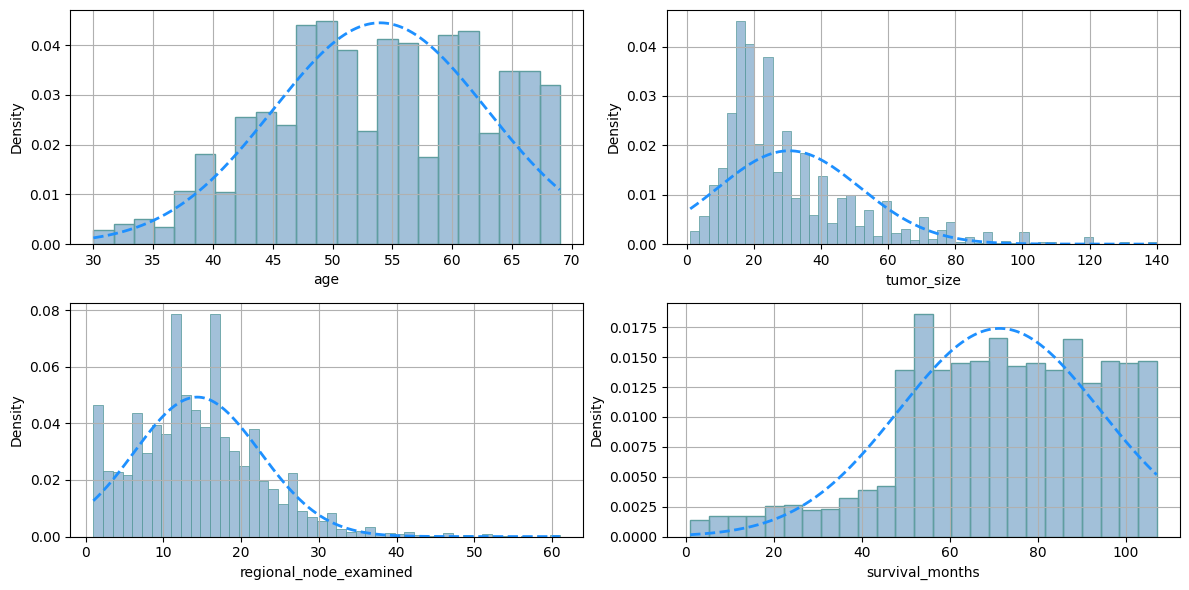

In [15]:
n_rows = 2
n_cols = 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(12,6))

# Flatten the 2D array of axes objects to simplify indexing
ax = ax.flatten()

for i, feature in enumerate(numerical_features):
    if i < len(ax):  # Make sure to only use the available axes
        # Plot the histogram
        sns.histplot(df_bc[feature], stat="density", ax=ax[i], color="steelblue", edgecolor="cadetblue", alpha=0.5)
        
        # Generate and plot the Gaussian curve
        x, gaussian_curve = fit_gaussian_to_feature(df_bc[feature])
        ax[i].plot(x, gaussian_curve, color="dodgerblue", linestyle="--", linewidth=2)  

        ax[i].grid(True, zorder=0)
        
# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

We see that most of the numerical features have a normal or *quasi*-normal distribution. Is there any correlation between these features? Let's make an heatmap plot.

<Axes: >

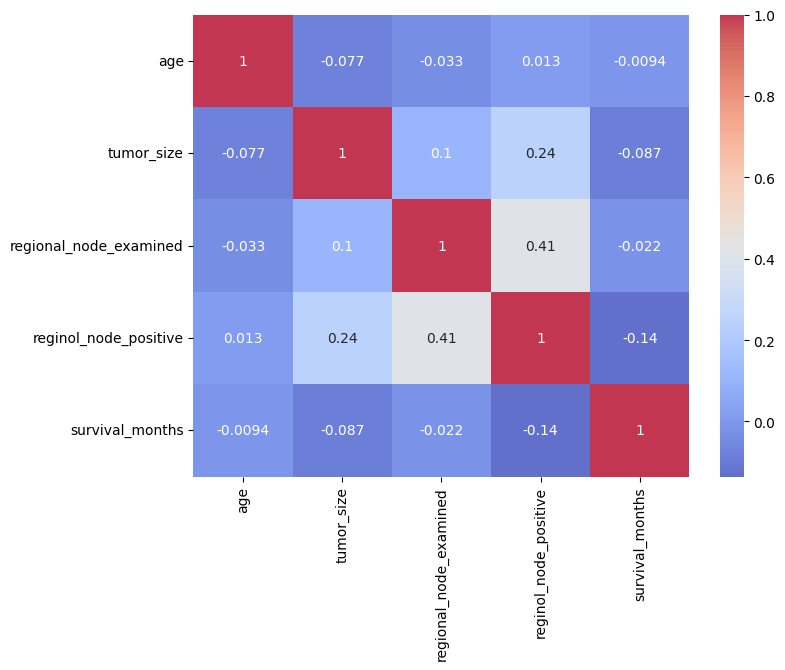

In [16]:
# Let's check out the correlation between numerical variables
fig, ax = plt.subplots(figsize=(8,6))

sns.heatmap(df_bc.corr(numeric_only=True) , annot =True , cmap="coolwarm", alpha=0.8)

Correlation coefficients are low, with the exception between `reginal_node_examined` and `reginal_node_positive`, which, as one may expect, are positively correlated. Let's also check the distribution of categorical features:

In [17]:
categorical_features = ["race", "marital_status", "t_stage_", "n_stage", "progesterone_status", "differentiate"]

In [18]:
def get_counts(df: pd.DataFrame, col_name: str):
    return df.groupby(col_name).size().reset_index(name="count")

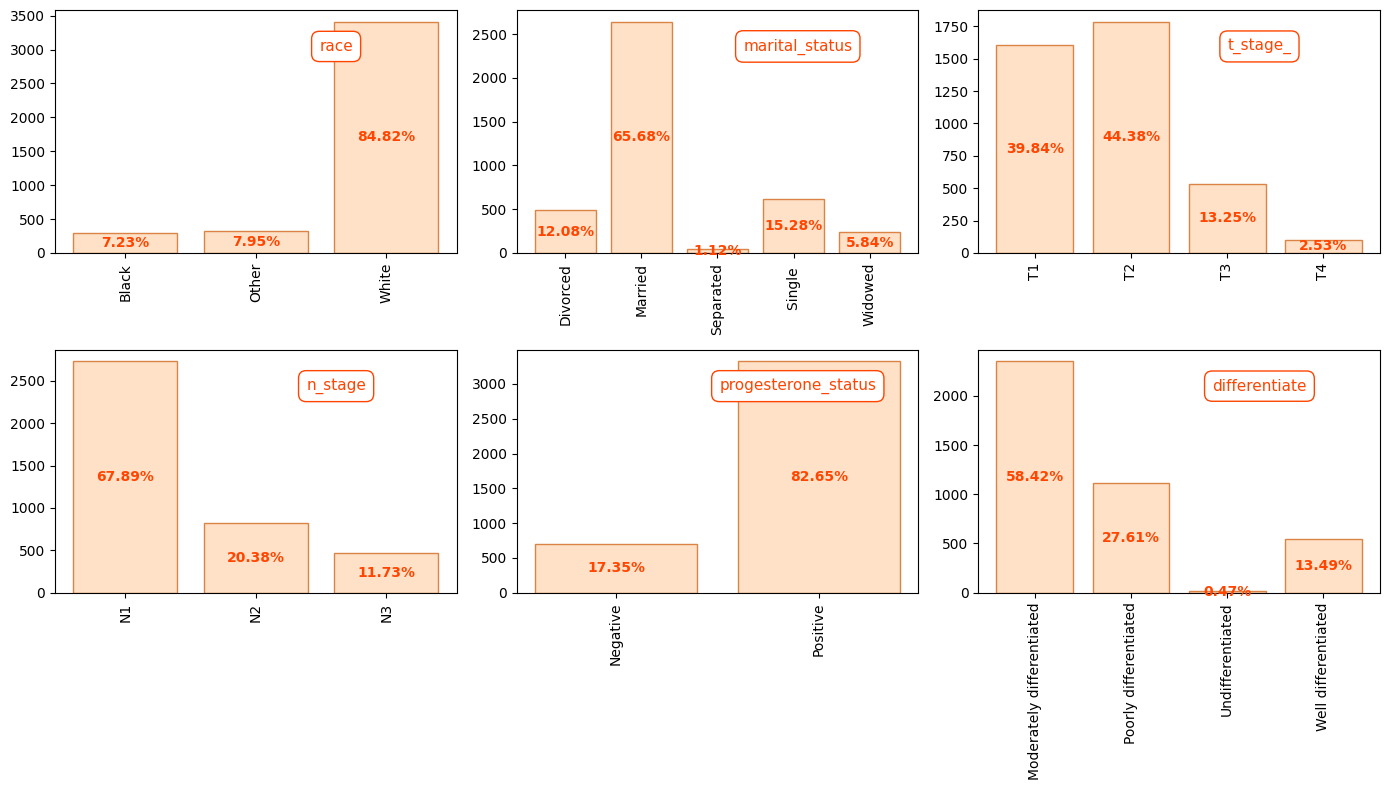

In [19]:
n_cols = 3
n_rows = len(categorical_features) // 3 

fig, ax  = plt.subplots(n_rows, n_cols, figsize=(14,8))

# Flatten the 2D array of axes objects to simplify indexing
ax = ax.flatten()

for i, feature in enumerate(categorical_features):
    
    df_counts = get_counts(df_bc, feature)
    percs = df_counts["count"]/df_counts["count"].sum()
    
    bars = ax[i].bar(df_counts[feature], df_counts["count"], color="peachpuff", edgecolor="chocolate", alpha=0.8)

    # Add text with a bounding box, using relative coordinates
    ax[i].text(
        0.7, 0.85, 
        feature,
        fontsize=11,
        color="orangered",
        ha='center', va='center',
        transform=ax[i].transAxes, 
        bbox=dict(
            facecolor='white', edgecolor='orangered', 
            boxstyle='round,pad=0.5')
        )
    
    # filling bars    
    for j, bar in enumerate(bars):
        x = bar.get_x()
        width = bar.get_width()
        height = bar.get_height()
        ax[i].text(
            x+width/2, 
            height/2, 
            f"{str(round(percs[j]*100, 2))}%", 
            ha="center", va="center", color="orangered", fontsize=10, fontweight="bold"
        )

    ax[i].set_xticklabels(df_counts[feature], rotation=90)
# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In general, most of the categorical features have all possibile values well represented, with few exceptions, e.g. most patients represented in the dataset are *white*.

Before fitting the decision tree, we need to apply some pre-processing steps:
1. apply one-hot encoding to categorical features, i.e. convert categorical features into $N$ columns representing each feature-value pairs;
2. combine one-hot encoded categorical and numerical features into a single new dataframe
3. split the dataset into a **training** and **test** set.

In [20]:
# Step 1: Select the categorical features and apply one-hot encoding
df_encoded = pd.get_dummies(df_bc[categorical_features], drop_first=True)

# Step 2: Select the numerical features
df_numerical = df_bc[numerical_features]

# Step 3: Combine both numerical and encoded categorical features into a new DataFrame
df_final = pd.concat([df_numerical, df_encoded], axis=1)

In [21]:
# Now df_final can be used to fit a decision tree
df_final.head()

,age,tumor_size,regional_node_examined,survival_months,race_Other,race_White,marital_status_Married,marital_status_Separated,marital_status_Single,marital_status_Widowed,t_stage__T2,t_stage__T3,t_stage__T4,n_stage_N2,n_stage_N3,progesterone_status_Positive,differentiate_Poorly differentiated,differentiate_Undifferentiated,differentiate_Well differentiated
0,68,4,24,60,False,True,True,False,False,False,False,False,False,False,False,True,True,False,False
1,50,35,14,62,False,True,True,False,False,False,True,False,False,True,False,True,False,False,False
2,58,63,14,75,False,True,False,False,False,False,False,True,False,False,True,True,False,False,False
3,58,18,2,84,False,True,True,False,False,False,False,False,False,False,False,True,True,False,False
4,47,41,3,50,False,True,True,False,False,False,True,False,False,False,False,True,True,False,False


In [22]:
# Split your data into features (X) and target variable (y)
X = df_final  
y = df_bc["status"]  

In [23]:
X_train , X_test , y_train , y_test = train_test_split(
    X, y , 
    test_size=0.2, shuffle=True,
    random_state= 43 , stratify=y
)

## Fit and tune the Decision Tree `max_depth`

When fitting a classical decision tree classifier, one of the most important hyperparameters to choose is the maximum depth of the tree (commonly referred to as `max_depth`). This parameter defines the maximum number of layers or levels the tree can have. Since it is not learned from the data but instead set manually or through tuning, different values of `max_depth` can lead to significantly different model behaviors and performance.

In general, increasing the `max_depth` allows the decision tree to grow more complex. A deeper tree can model increasingly fine-grained decision rules and will typically result in higher training accuracy, since the model has more flexibility to fit the training data—sometimes even memorizing it entirely. In fact, if the depth is unrestricted, a decision tree can continue splitting until each leaf contains only a single sample, achieving **perfect accuracy** on the training set.

However, as seen with many machine learning models, **high training accuracy does not necessarily mean good generalization**. In fact, overly complex trees tend to **overfit**: they perform well on the training data but poorly on unseen data (i.e., the test set), capturing noise or patterns that do not generalize.

To better estimate how well the model will perform on unseen data, we use a technique called cross-validation. **Cross-validation** involves splitting the dataset into several partitions (or folds), then training the model on some of them and evaluating it on the remaining ones. This process is repeated multiple times, and the results are averaged to obtain a more robust estimate of model performance. The final result is a cross-validation score, which usually reflects the model’s accuracy or another performance metric averaged over the validation folds.

A typical procedure for tuning the max_depth works as follows:

1. Choose a range of possible depths (e.g., from 1 to 20).
2. Train a decision tree for each candidate value of max_depth.
3. For each tree, compute the training accuracy and the cross-validation score.

Compare the results:
- Training accuracy typically increases with depth.
- Cross-validation score often increases at first but eventually decreases when the model starts overfitting.

The goal is to select the value of max_depth that provides the best generalization, i.e., the highest cross-validation score before it starts to drop. This depth is considered the optimal tree depth, as it strikes the right balance between underfitting (too shallow) and overfitting (too deep).

In [24]:
# Set max_depths
max_depths = list(range(1, 13, 1))

In [25]:
mean_cross_val_score = []
train_accuracies = []

Below, we cycle over different `max_depth`, fit a Decision Tree classifier (as provided by the `scikit-learn` library), computing both the cross-validation score and the training accuracy. As the split criterion, we use the *Gini index* introduced above:

In [26]:
# Cycling over max_depth, fitting the model using a Gini index measure
for max_depth in max_depths:
    tree = DecisionTreeClassifier(criterion='gini', max_depth=max_depth)

    scores = cross_val_score(tree, X_train, y_train, cv=5)
    mean_cross_val_score.append(scores.mean())

    # predicting train
    tree.fit(X_train, y_train)
    train_accuracy = accuracy_score(y_train, tree.predict(X_train))
    train_accuracies.append(train_accuracy)

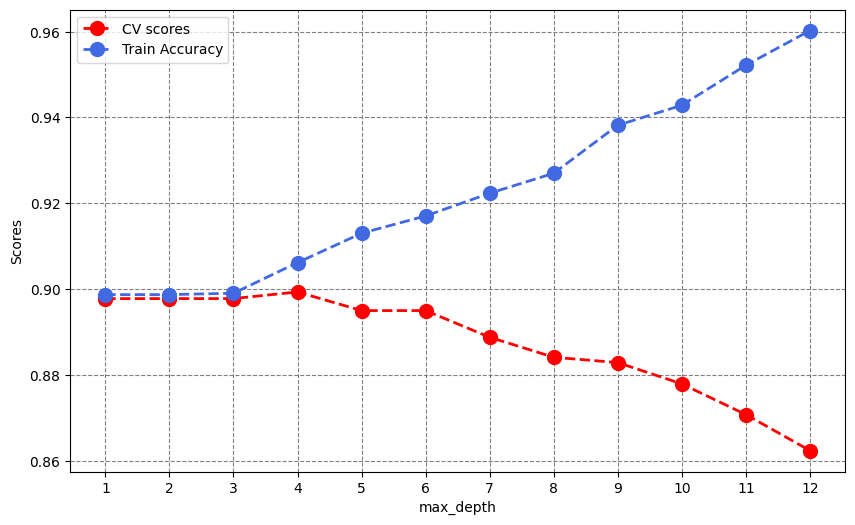

In [27]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(max_depths, mean_cross_val_score, marker="o", label="CV scores", color="red", linestyle="--", linewidth=2, markersize=10)
ax.plot(max_depths, train_accuracies, marker="o", color="royalblue", label="Train Accuracy", linestyle="--", linewidth=2, markersize=10)

ax.set_xlabel("max_depth")
ax.set_ylabel("Scores")

ax.set_xticks(range(1, 13, 1))

ax.grid(True, linestyle="--", color="grey")
ax.legend()
plt.show()

As we can see, the cross-validation score starts increasing but then decreases after `max_depth=5`. The training accuracy keeps increasing, reaching very high values for deep trees. An optimal decision tree classifier on the given dataset may have 3 or 4 layers:

In [28]:
optimal_tree = DecisionTreeClassifier(criterion='gini', max_depth=3)
optimal_tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3)

An interesting characteristic of decision trees is that they can be easily visualized, and from the visualization, one can extract simple, interpretable decision rules to classify new data.

Below is a code snippet showing how to use `matplotlib` to visualize the optimally fitted decision tree:

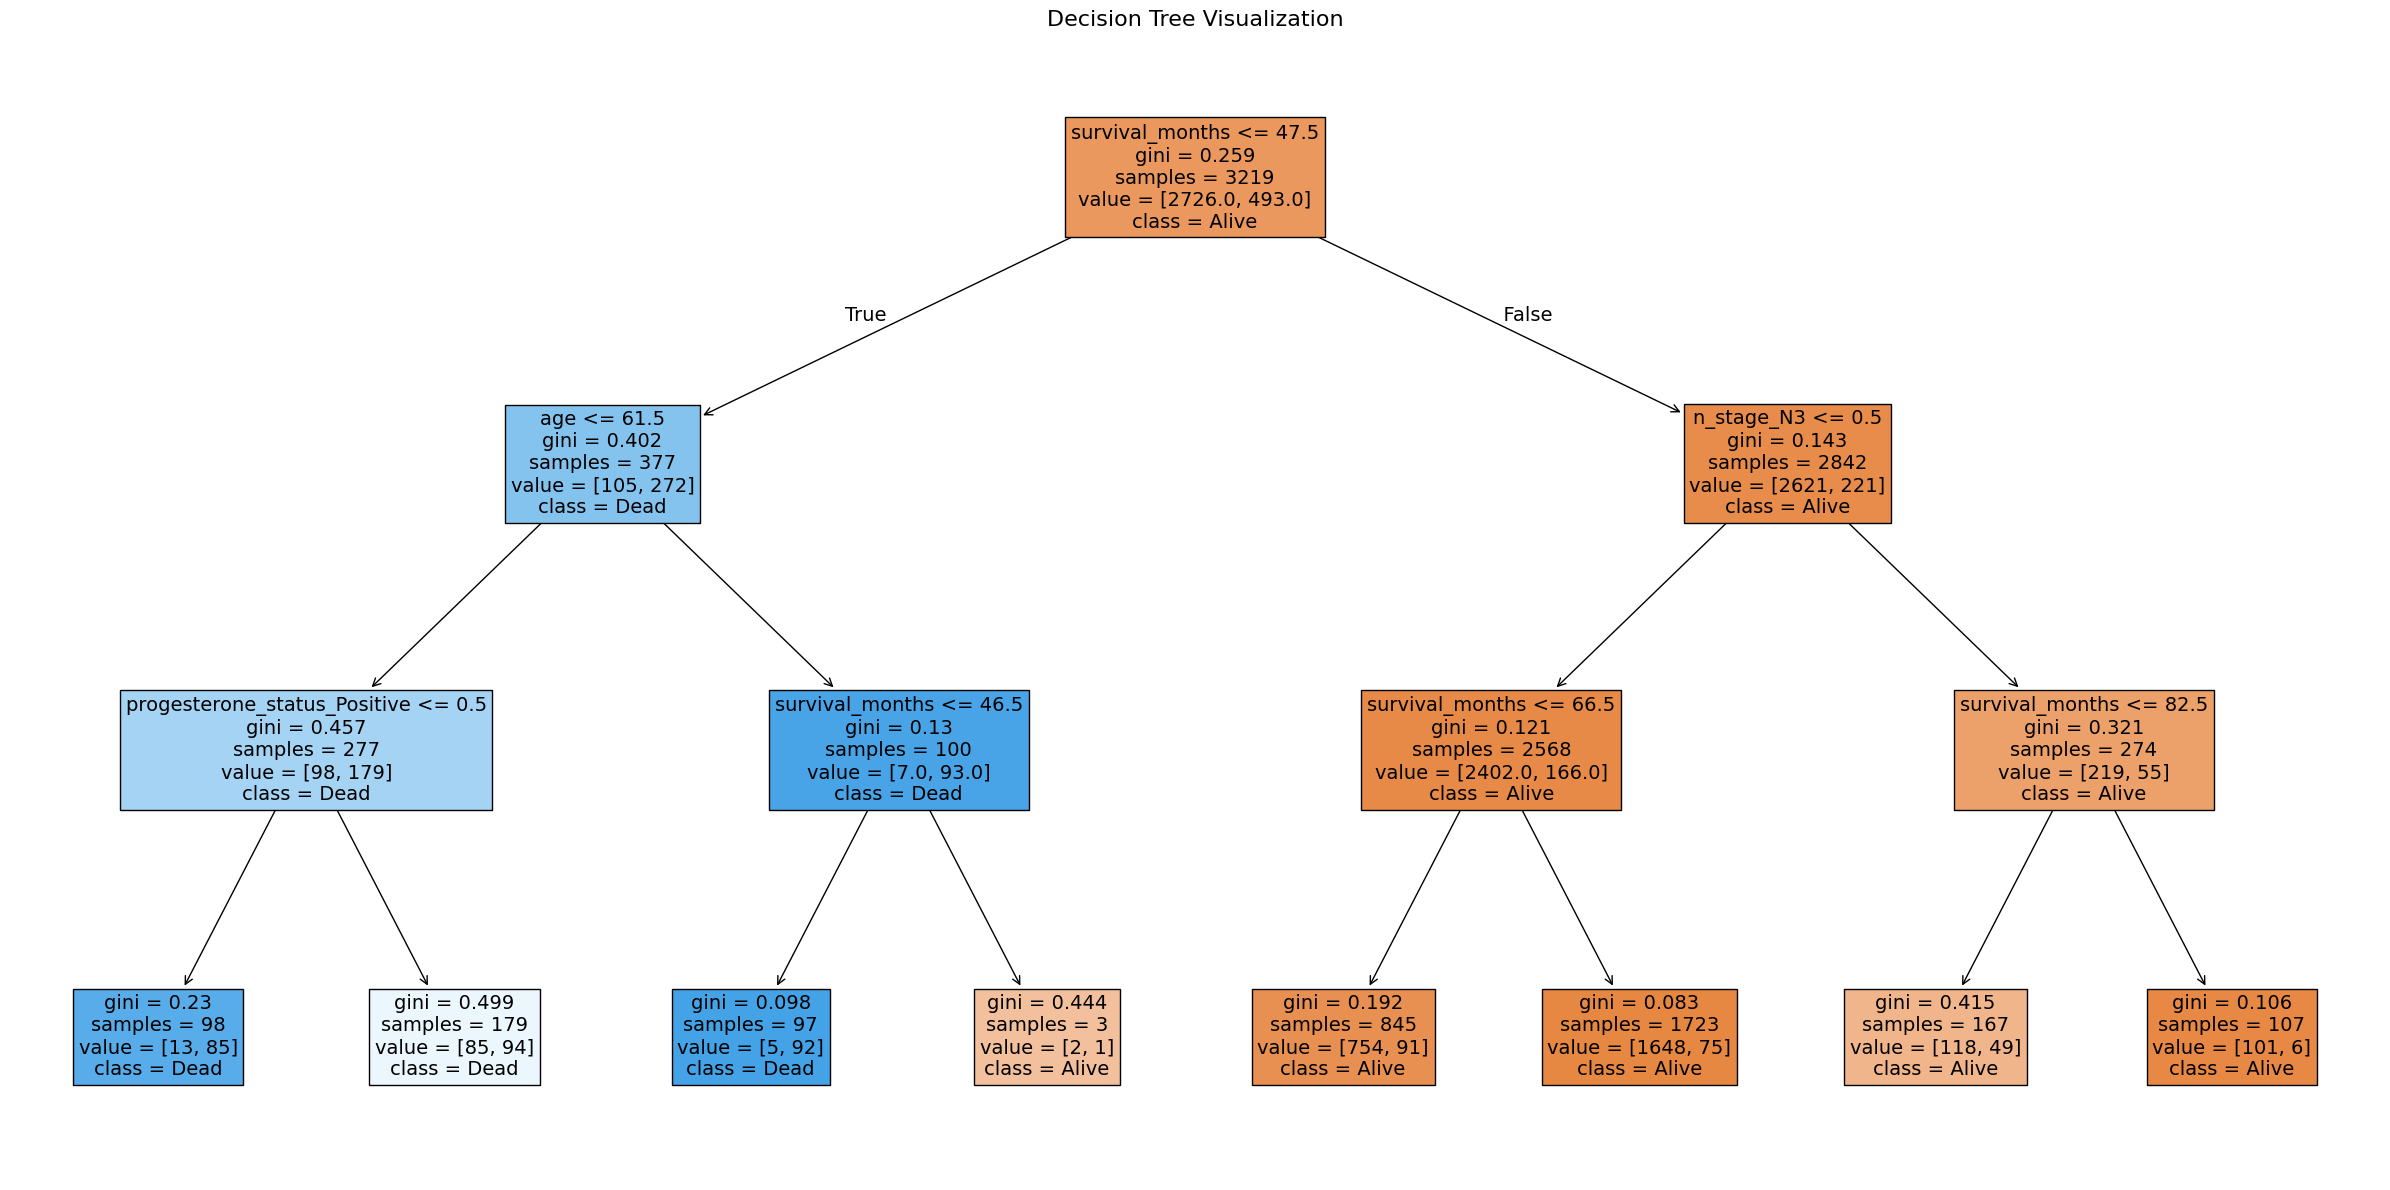

In [29]:
# Convert class names to strings
class_names = [str(cls) for cls in optimal_tree.classes_]

# Plotting the decision tree
fig, ax = plt.subplots(figsize=(24, 12))  

# Plot the decision tree
plot_tree(optimal_tree, 
          filled=True, 
          feature_names=X_train.columns, 
          class_names=[str(cls) for cls in optimal_tree.classes_],
          fontsize=14,  # Adjust font size
          proportion=False,
         ax=ax
         )  # Set to False to keep node sizes standard

ax.set_title('Decision Tree Visualization', fontsize=16)
plt.tight_layout()  
plt.show()

In [30]:
len(y_test[y_test=="Dead"])

123

In [31]:
# Step 3: Make predictions
y_pred = optimal_tree.predict(X_test)

# Step 4: Calculate accuracy and F1-score
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

#Calculate precision
precision = precision_score(y_test, y_pred, pos_label="Dead")
print(f'Precision: {precision:.2f}')

# Calculate recall
recall = recall_score(y_test, y_pred, pos_label="Dead")
print(f'Recall: {recall:.2f}')

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

Accuracy: 0.90
Precision: 0.72
Recall: 0.55


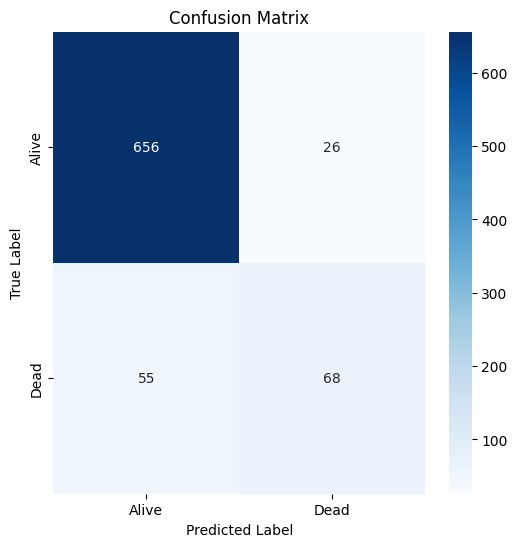

In [32]:
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Alive', 'Dead'], yticklabels=['Alive', 'Dead'], ax=ax)

ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix')
plt.show()